# How can the company improve collaboration?

## 📖 Background
You work in the analytics department of a multinational company, and the head of HR wants your help mapping out the company's employee network using message data. 

They plan to use the network map to understand interdepartmental dynamics better and explore how the company shares information. The ultimate goal of this project is to think of ways to improve collaboration throughout the company. 

## 💾 The data

The company has six months of information on inter-employee communication. For privacy reasons, only sender, receiver, and message length information are available [(source)](https://snap.stanford.edu/data/CollegeMsg.html). 

#### Messages has information on the sender, receiver, and time.
- "sender" - represents the employee id of the employee sending the message.
- "receiver" - represents the employee id of the employee receiving the message.
- "timestamp" - the date of the message.
- "message_length" - the length in words of the message.

#### Employees has information on each employee;
- "id" - represents the employee id of the employee.
- "department" - is the department within the company. 
- "location" - is the country where the employee lives.
- "age" - is the age of the employee.

_**Acknowledgments:** Pietro Panzarasa, Tore Opsahl, and Kathleen M. Carley. "Patterns and dynamics of users' behavior and interaction: Network analysis of an online community." Journal of the American Society for Information Science and Technology 60.5 (2009): 911-932._

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

In [74]:
messages = pd.read_csv('data/messages.csv', parse_dates= ['timestamp'])

In [75]:
employees = pd.read_csv('data/employees.csv')

In [76]:
employees[employees.id.isin([605,598])]

,id,department,location,age
278,598,Operations,US,38
280,605,Admin,France,31


## Executive Summary

- The departments with the most activity are Sales, Operations and Admin
- The employee with the most connections is 598 from Operations department. And the one with more messages is 605 from Admin department
- The most influent employee 605 and the department is Admin

Before start doing any analysis it's always good to check for inconsistencies

In [77]:
# checking the data for inconsistencies
employees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 664 entries, 0 to 663
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          664 non-null    int64 
 1   department  664 non-null    object
 2   location    664 non-null    object
 3   age         664 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 20.9+ KB


In [78]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3512 entries, 0 to 3511
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   sender          3512 non-null   int64         
 1   receiver        3512 non-null   int64         
 2   timestamp       3512 non-null   datetime64[ns]
 3   message_length  3512 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 109.9 KB


There's no null data in both dataset

In [79]:
employees.describe()

,id,age
count,664.000000,664.000000
mean,793.710843,40.921687
std,498.462869,10.489521
min,3.000000,22.000000
25%,364.750000,33.000000
50%,725.500000,40.000000
75%,1191.500000,50.000000
max,1890.000000,59.000000


In [80]:
employees.department.value_counts()

Sales          161
Admin          140
Operations     134
Engineering    100
IT              77
Marketing       52
Name: department, dtype: int64

In [81]:
employees.location.value_counts()

US         277
France     157
Germany     99
UK          70
Brasil      61
Name: location, dtype: int64

In [82]:
messages.describe()

,sender,receiver,message_length
count,3512.000000,3512.000000,3512.000000
mean,591.953303,627.052677,48.450740
std,397.953749,460.981865,22.857461
min,79.000000,3.000000,10.000000
25%,332.000000,277.000000,29.000000
50%,509.000000,509.000000,49.000000
75%,605.000000,878.000000,68.000000
max,1881.000000,1890.000000,88.000000


Everything seems perfectly fine, so i'm not making any change

## Departments activity

In [83]:
# including the 'department' collumn to the messages as for the sender and the receiver

dept = employees[['id','department']]

messages_dept = messages.merge(dept,right_on='id',left_on='sender')\
.merge(dept,right_on='id',left_on='receiver',suffixes=('_sender','_receiver')).drop(['id_sender','id_receiver'],axis=1)

In [84]:
#grouping the messages by the department of the employee that sent the message
dept_sent = messages_dept.groupby('department_sender')['sender'].count().sort_values(ascending=False)
dept_sent

department_sender
Sales          1551
Operations     1013
Admin           857
IT               49
Engineering      26
Marketing        16
Name: sender, dtype: int64

In [85]:
#grouping the messages by the department of the employee that received the message
dept_receiv = messages_dept.groupby('department_receiver')['receiver'].count().sort_values(ascending=False)
dept_receiv

department_receiver
Sales          1229
Operations      845
Admin           797
Engineering     252
IT              249
Marketing       140
Name: receiver, dtype: int64

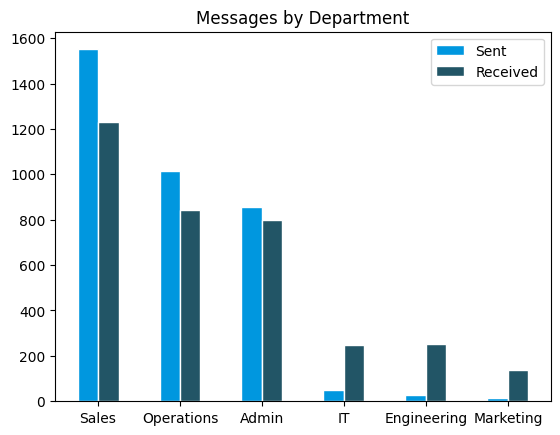

In [86]:
#plotting the messages per department
plt.bar(dept_sent.index, dept_sent.values, color='#0097DF', label='Sent',width=-0.25,edgecolor='white',align='edge')
plt.bar(dept_receiv.index, dept_receiv.values, color='#225566', label='Received',width=0.25,edgecolor='white',align='edge')
plt.title('Messages by Department')
plt.legend()
plt.show()

The most active department is Sales, and the least one is Marketing

## Employees connections

In [87]:
messages_num_sender = pd.DataFrame(messages.groupby('sender')['receiver'].count().sort_values(ascending=False))\
.reset_index().rename(columns={'receiver':'sent','sender':'employee'})
messages_num_receiver = pd.DataFrame(messages.groupby('receiver')['sender'].count().sort_values(ascending=False))\
.reset_index().rename(columns={'sender':'received','receiver':'employee'})

num_messages = messages_num_receiver.merge(messages_num_sender,on='employee',how='outer')
num_messages = num_messages.fillna(0)
num_messages['total_messages'] = num_messages.sent + num_messages.received
num_messages

,employee,received,sent,total_messages
0,281,60.0,0.0,60.0
1,704,54.0,0.0,54.0
2,308,51.0,0.0,51.0
3,236,47.0,0.0,47.0
4,830,47.0,0.0,47.0
...,...,...,...,...
659,1780,0.0,1.0,1.0
660,280,0.0,1.0,1.0
661,977,0.0,1.0,1.0
662,521,0.0,1.0,1.0


In [88]:
connections_sender = pd.DataFrame(messages.groupby('sender')['receiver'].nunique().sort_values(ascending=False))\
.reset_index().rename(columns={'receiver':'sent','sender':'employee'})
connections_receiver = pd.DataFrame(messages.groupby('receiver')['sender'].nunique().sort_values(ascending=False))\
.reset_index().rename(columns={'sender':'received','receiver':'employee'})

connections = connections_receiver.merge(connections_sender,on='employee',how='outer')
connections = connections.fillna(0)
connections

,employee,received,sent
0,194,13.0,0.0
1,32,11.0,0.0
2,249,9.0,0.0
3,1283,8.0,0.0
4,103,8.0,0.0
...,...,...,...
659,1605,0.0,1.0
660,186,0.0,1.0
661,1569,0.0,1.0
662,280,0.0,1.0


The employee with the most connections is the one with id number 598, having received messages for 7 different employees, and sent to 77. 

Another interesting view is for the number of messages, where employee 598 has sent 187 and received 11, while employee 605 has sent 459 and receved 37, so althought is not the employee with most connections is the one with the most messages

## Influencers

In [89]:
#create a new column to check if the message influent other
#the criteria for a influent message i used is if one message triggered the receiver to send one within 15 minutes

messages_dept['influent'] = False 
for index, msg in messages_dept.iterrows(): 
    if (messages_dept[(messages_dept['sender'] == msg.receiver) & (messages_dept['timestamp'] >= msg.timestamp) & (messages_dept['timestamp'] <= msg.timestamp+timedelta(minutes=15))]).empty:
        messages_dept.at[index, 'influent'] = False
    else:
        messages_dept.at[index, 'influent'] = True

In [90]:
messages_dept.groupby('sender')['influent'].sum().sort_values(ascending=False)

sender
605     27
317     13
734     12
422      6
389      5
        ..
643      0
521      0
518      0
516      0
1881     0
Name: influent, Length: 85, dtype: int64

In [91]:
messages_dept.groupby('receiver')['influent'].sum().sort_values(ascending=False)

receiver
605     26
317     14
734     11
389      7
337      7
        ..
482      0
485      0
487      0
488      0
1890     0
Name: influent, Length: 617, dtype: int64

In [92]:
messages_dept.groupby('department_sender')['influent'].sum().sort_values(ascending=False)

department_sender
Admin          31
Sales          28
Operations     20
Marketing       3
Engineering     0
IT              0
Name: influent, dtype: int64

In [93]:
messages_dept.groupby('department_receiver')['influent'].sum().sort_values(ascending=False)

department_receiver
Admin          33
Sales          32
Operations     17
Engineering     0
IT              0
Marketing       0
Name: influent, dtype: int64

 As there are no specified criteria for what would be an influent employee or department, I considered it as being if a message triggered the receiver to send a message within 15 minutes.

 Of course, only with this data there's no way to tell if the message sent really triggered anything, but that's what I'm considering as influential.

 In this scenario, the most influential employee is 605 and the most influential department is Admin.

## Where to focus?

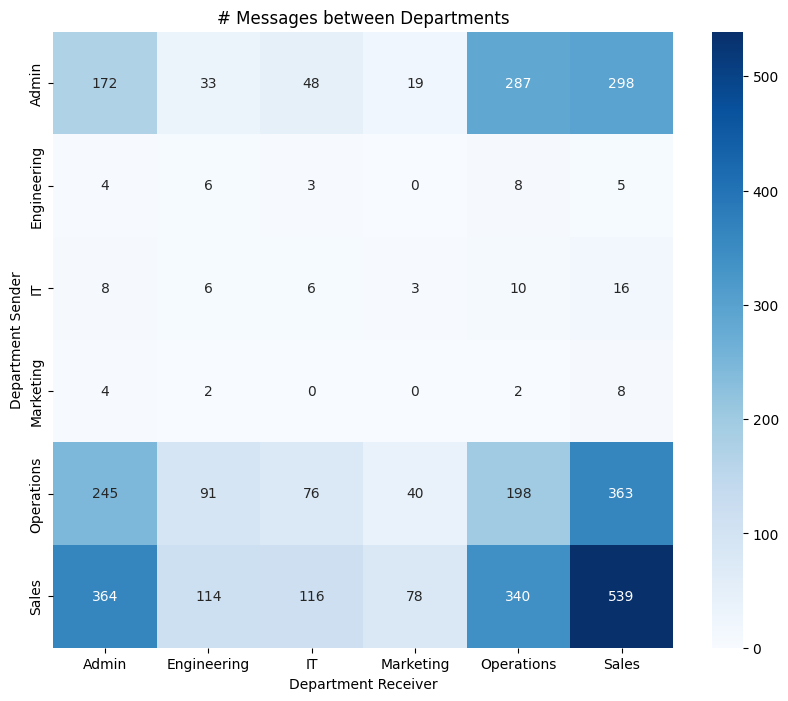

In [94]:
# Create a pivot table to count the number of messages between each department sender and receiver
heatmap_data = messages_dept.pivot_table(index='department_sender', columns='department_receiver', values='sender', aggfunc='count', fill_value=0)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt='g')
plt.title('# Messages between Departments')
plt.xlabel('Department Receiver')
plt.ylabel('Department Sender')
plt.show()

We can see in the heatmap that the Marketing department is involved in every connection with 0 messages, and is the only one that doesn't have a single message to its own department. The IT and the Engineering departments are also a little behind the others, but Marketing should be the top 1 priority for the HR team by now

### Conclusion

In this anlysis was discovered that the department with the most activity is Sales, and the one with less is Marketing. The employee with most connections is 598 that work for Operations department, but the one with more messages os 605 from Admin, which are the most influential employee and department. The influential title was used for messages that triggered the receiver to message other people in between 15 minutes. At the end its also possible to see that the departments connections with 0 messages all envolve Marketing, that has not sent any message to the IT and the own Marketing, and also haven't received messages from Engineering. Curiosly these 3 (IT, Engineering, Marketing) are the bottom 3 from messages sent and received. With that said HR should focus in Marketing department, but IT and Engerireeng are also a bit behind in communication terms